# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns
from tqdm import tqdm
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy as maskable_evaluate_policy
from scipy import stats
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly


from electricity_market.electricity_market_env import ElectricityMarketEnv, EnvConfig


In [ ]:
#| export
TOTAL_TIMESTEPS = 20 # 5000
N_EPISODES = 10 # 10_000
N_TRAILS = 10
N_JOBS = 7
seeds = [123456] #, 234567] #, 345678, 456789, 567890]
number_of_frames = 5
frame_size = TOTAL_TIMESTEPS // number_of_frames
frames = np.array(list(range(frame_size, TOTAL_TIMESTEPS + 1, frame_size)), dtype=int)

env_config = EnvConfig(max_timestep=TOTAL_TIMESTEPS)
results = {}

In [ ]:
#| export
class Agent(ABC):
    def __init__(self):
        pass

    @classmethod
    def mask_fn(cls, env: ElectricityMarketEnv) -> np.ndarray:
        return env.action_masks()

    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm | None,
            env: ElectricityMarketEnv | DummyVecEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        raise NotImplementedError

    @classmethod
    def evaluate_policy(
            cls, hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        raise NotImplementedError

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError



In [ ]:
#| export
class MaskableRandomAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm,  # Unused for a random agent
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        episode_rewards = []

        for _ in range(n_episodes):
            obs, _ = env.reset(seed=seed)
            done = False
            total_reward = 0.0

            while not done:
                action_mask = env.action_masks()
                valid_actions = np.where(action_mask)[0]  # Get valid actions
                action = np.random.choice(valid_actions)  # Select random valid action

                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if truncated:
                    break

            episode_rewards.append(total_reward)

        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        all_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn)

            seed_rewards = []

            for _ in tqdm(frames, desc="frames"):
                rewards = cls.collect_episodes_rewards(None, env, n_episodes, deterministic=True, render=render, seed=seed)
                seed_rewards.append(rewards)
            seed_rewards = np.array(seed_rewards)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)

        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError


In [ ]:
#| export
class MaskablePPOAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: MaskablePPO,
            env: DummyVecEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False,
            seed: int | None = None
    ) -> list[float]:
        env.seed(seed=seed)
        episode_rewards, _ = maskable_evaluate_policy(
            model, env, deterministic=deterministic, use_masking=True,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in tqdm(frames, desc="frames", leave=False):
                model.learn(
                    total_timesteps=frame, use_masking=True, reset_num_timesteps=False
                )
                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render, seed=seed
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        n_steps = trial.suggest_int('n_steps', 32, 1024, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
        ent_coef = trial.suggest_float('ent_coef', 0.0, 0.02)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)

        trial_seed_rewards = []

        for seed in tqdm(seeds, desc="seeds"):
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), maskable_ppo_agent.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                clip_range=clip_range,
                max_grad_norm=max_grad_norm,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS, use_masking=True)
            episode_rewards = cls.collect_episodes_rewards(
                model, env, n_episodes=n_episodes, deterministic=True, render=False, seed=seed
            )

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance


In [ ]:
#| export
# Function to compute aggregated metrics for each algorithm
def aggregate_func(x):
    return np.array([
        metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        metrics.aggregate_mean(x)
    ], dtype=np.float64)

# Aggregate results across seeds and episodes for each algorithm
def aggregate_over_checkpoints(evaluation_results):
    aggregated_results = {}
    for algorithm, results in evaluation_results.items():
        # results.shape is (num_seeds, num_checkpoints, num_episodes)
        # We aggregate across seeds and episodes for each checkpoint
        agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
        aggregated_results[algorithm] = agg_results
    return aggregated_results

# Function to plot aggregate metrics (Median, IQM, Mean)
def plot_aggregate_metrics(aggregated_results, algorithms):
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

# Function to plot the probability of improvement between two algorithms
def plot_probability_of_improvement(evaluation_results, algorithms):
    for alg1, alg2 in combinations(algorithms, 2):
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

# Function to plot the sample efficiency curve
def plot_sample_efficiency_curve(evaluation_results, frames):
    global number_of_frames
    sample_efficiency_dict = {
        alg: results[:, :, :]
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(number_of_frames)])
    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)

    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()

# Function to plot performance profiles (linear and non-linear scaling)
def plot_performance_profiles(evaluation_results, algorithms):
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()


def plot_learning_curves(evaluation_results, algorithms):
    """Plots learning curves for multiple algorithms."""
    plt.figure(figsize=(12, 8))

    n_episodes = evaluation_results[algorithms[0]].shape[2]
    episodes = np.arange(1, n_episodes + 1)

    for algorithm in algorithms:
        mean_rewards_per_episode = np.mean(evaluation_results[algorithm], axis=(0, 1))
        std_rewards_per_episode = np.std(evaluation_results[algorithm], axis=(0, 1))
        plt.plot(episodes, mean_rewards_per_episode, label=algorithm, marker='o', linestyle='-')
        plt.fill_between(episodes, mean_rewards_per_episode - std_rewards_per_episode,
                         mean_rewards_per_episode + std_rewards_per_episode, alpha=0.2)

    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('Mean Episode Reward', fontsize=14)
    plt.title('Learning Curves of Multiple Algorithms', fontsize=16, fontweight='bold')

    plt.legend(loc='best', fontsize=12, title="Algorithms")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout(pad=2.0)
    plt.show()

# Main function to call all the individual plot functions
def plot_evaluation_results(evaluation_results: dict) -> None:
    global frames
    algorithms = list(evaluation_results.keys())

    # Aggregate the results across seeds and checkpoints
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Plot aggregate metrics
    plot_aggregate_metrics(aggregated_results, algorithms)

    # Plot Probability of Improvement
    plot_probability_of_improvement(evaluation_results, algorithms)

    # Plot Sample Efficiency Curve
    plot_sample_efficiency_curve(evaluation_results, frames)

    # Plot Performance Profiles
    plot_performance_profiles(evaluation_results, algorithms)

    # Plot Learning Curves
    plot_learning_curves(evaluation_results, algorithms)


In [ ]:
#| export
maskable_random_agent = MaskableRandomAgent()
maskable_ppo_agent = MaskablePPOAgent()

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
#| export
results["MaskableRandomAgent"] = maskable_random_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)














seeds:   0%|          | 0/1 [00:00<?, ?it/s]













frames:   0%|          | 0/5 [00:00<?, ?it/s]













frames:  40%|████      | 2/5 [00:00<00:00, 11.24it/s]













frames: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]













seeds: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-5.6833415  -6.11687567 -5.25107386 -3.82964711 -7.85110049
   -6.23612854 -5.9497741  -5.04818422 -4.52573764 -3.99719151]
  [-7.34486363 -7.44984475 -8.1011722  -5.13990571 -7.25107386
   -6.25107386 -6.73465748 -5.56720588 -4.36040698 -5.25107386]
  [-4.57868176 -4.54944462 -7.         -4.64775749 -5.11690545
   -6.85843886 -5.10102926 -4.28558981 -5.08675828 -5.18950847]
  [-5.98867872 -4.60578166 -4.54713039 -5.73117021 -4.60724706
   -5.7082284  -5.66839618 -3.73127363 -2.35328878 -5.25375429]
  [-2.65235443 -5.15217657 -4.60724706 -7.43253917 -5.76121508
   -6.45582431 -5.23748577 -4.9727961  -5.06020156 -2.28008435]]]


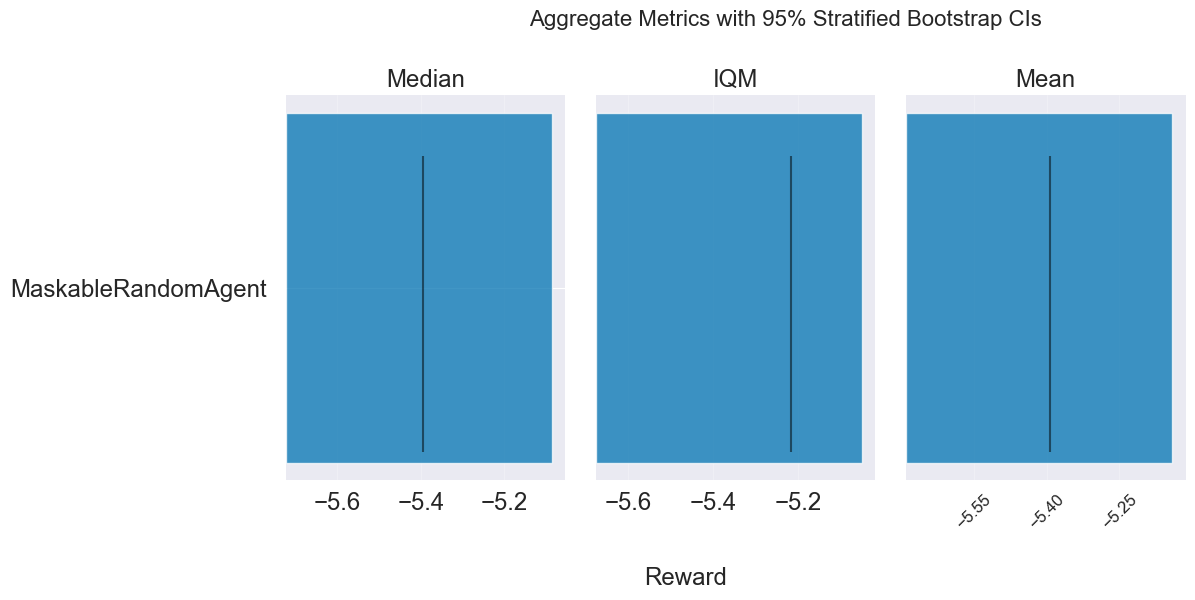

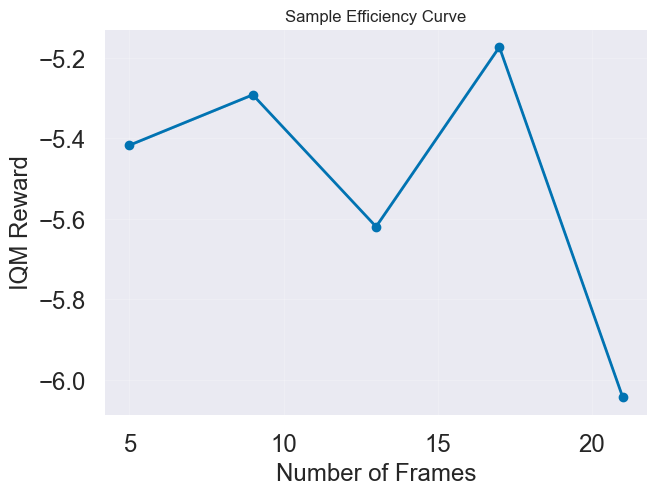

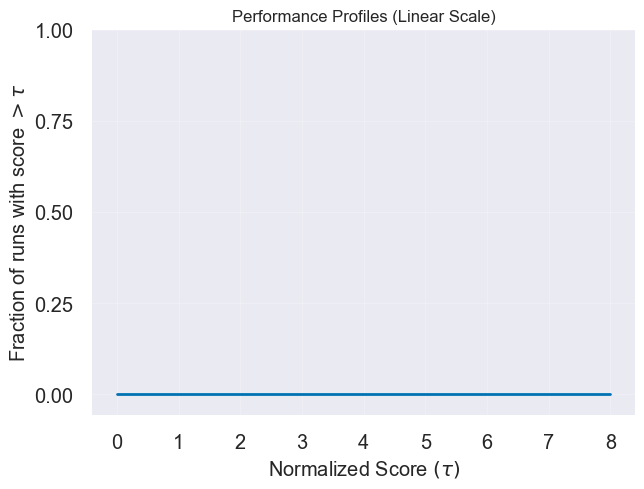

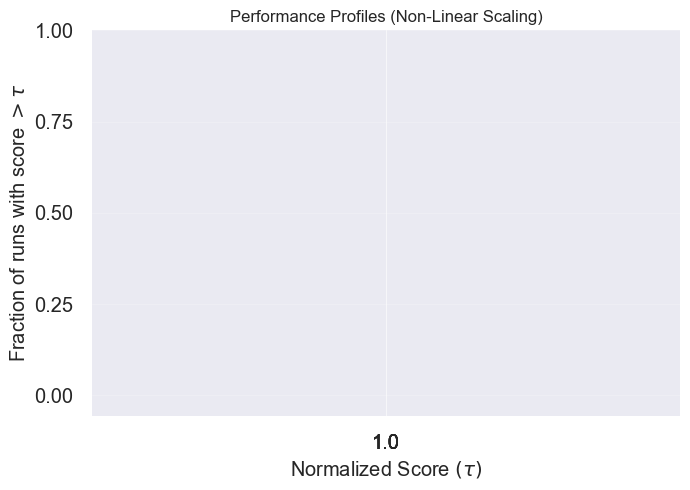

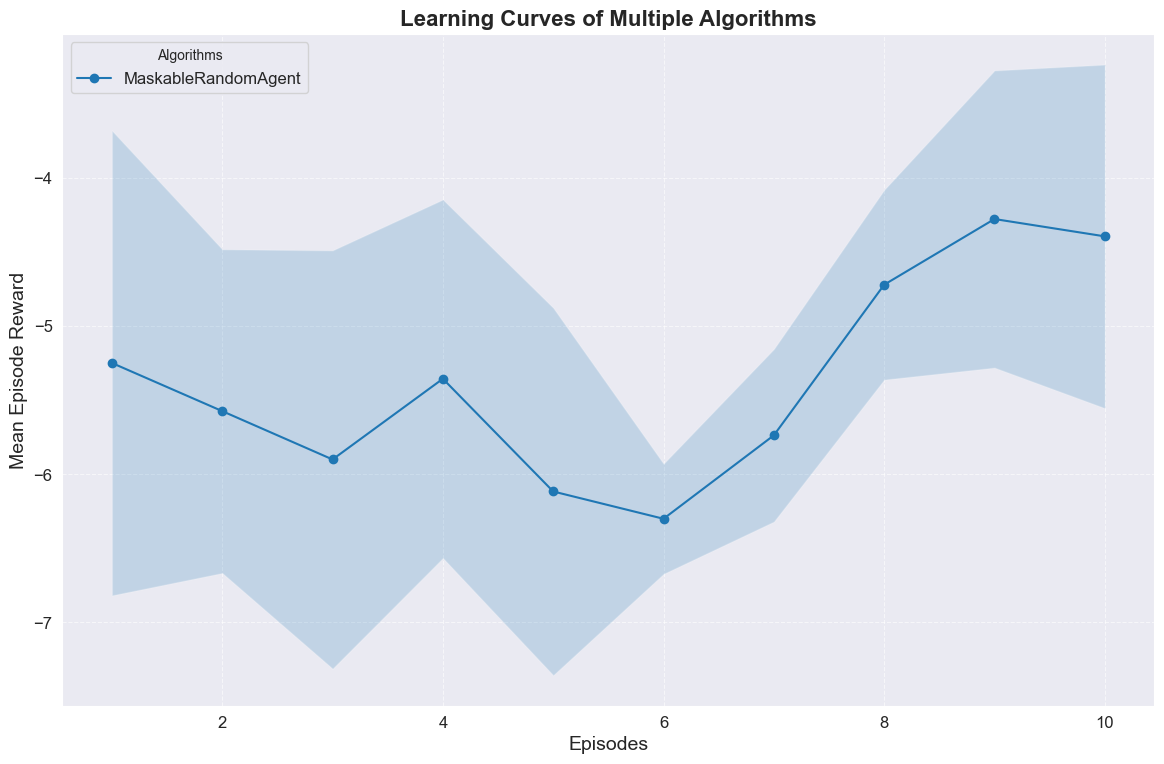

In [ ]:
#| export
plot_evaluation_results(results)

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Baseline"] = maskable_ppo_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)














seeds:   0%|          | 0/1 [00:00<?, ?it/s]













frames:   0%|          | 0/5 [00:00<?, ?it/s]













frames:  20%|██        | 1/5 [00:51<03:24, 51.16s/it]













frames:  40%|████      | 2/5 [01:43<02:35, 51.88s/it]













frames:  60%|██████    | 3/5 [02:34<01:42, 51.32s/it]













frames:  80%|████████  | 4/5 [03:25<00:51, 51.51s/it]













frames: 100%|██████████| 5/5 [04:16<00:00, 51.32s/it]













                                                     












seeds: 100%|██████████| 1/1 [04:17<00:00, 257.03s/it]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-5.5      -6.5      -7.       -7.       -6.       -6.397075 -7.5
   -6.389735 -6.5      -7.      ]
  [-4.0045   -5.560607 -6.098236 -6.185716 -6.5      -6.03582  -6.5
   -3.914671 -6.       -5.537213]
  [-3.344967 -4.452371 -6.5      -4.906156 -4.410301 -3.973095 -4.410949
   -2.30034  -3.891089 -4.536879]
  [-6.186535 -4.808077 -2.718353 -3.338673 -2.212101 -6.13816  -5.609148
   -5.95947  -7.607592 -2.805224]
  [-0.119002 -2.451123 -4.60023  -3.15402  -2.215899 -1.253671 -1.747727
   -4.100146 -1.233246 -3.629772]]]


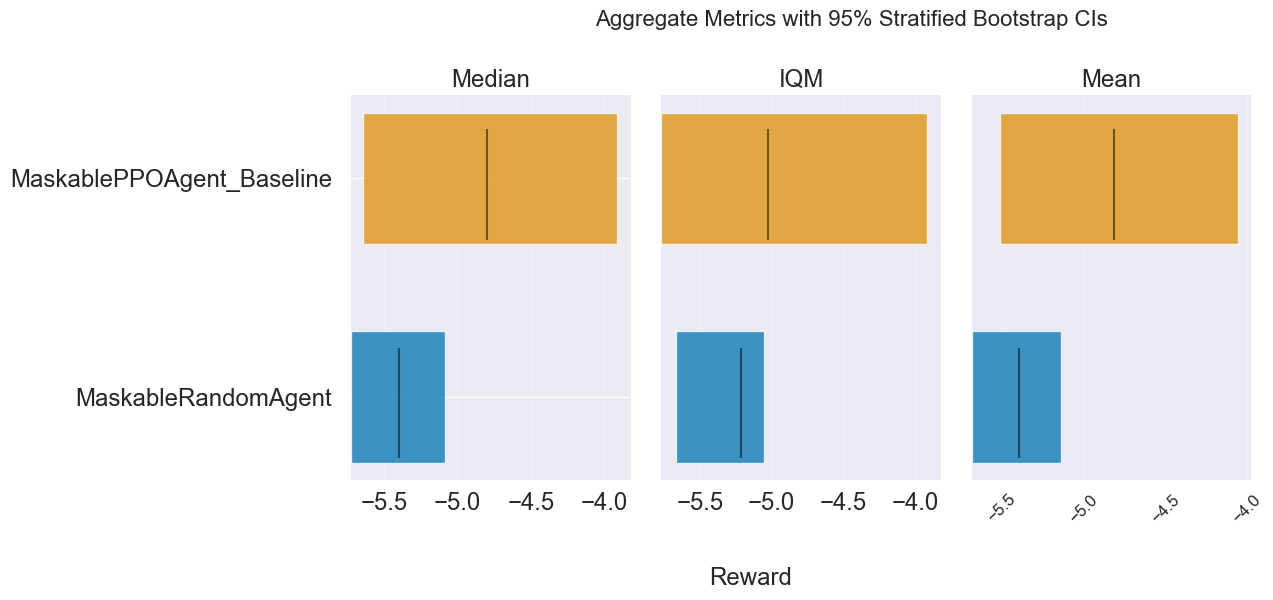

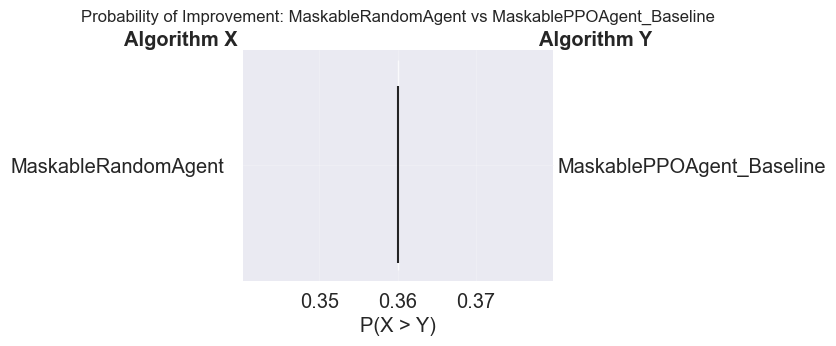

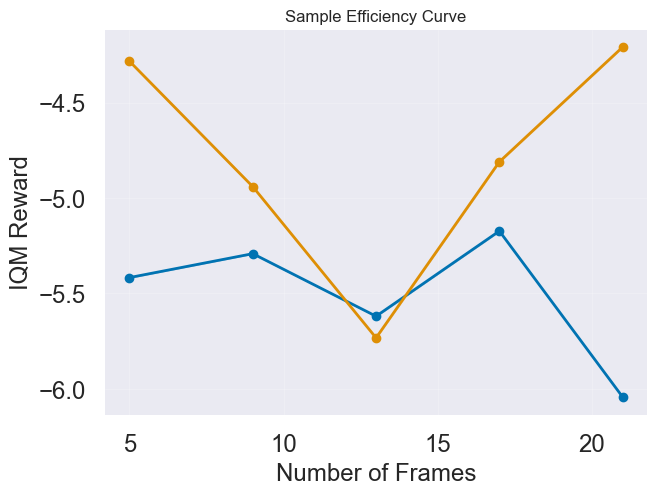

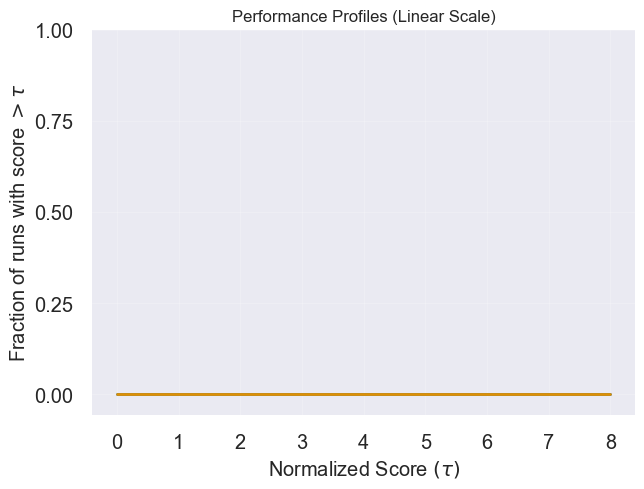

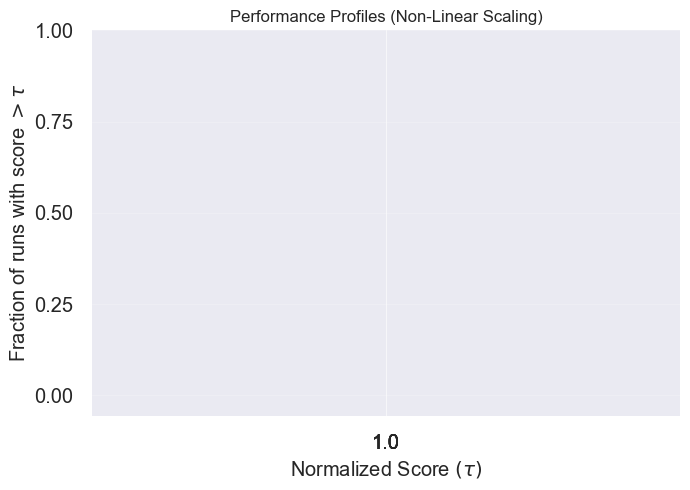

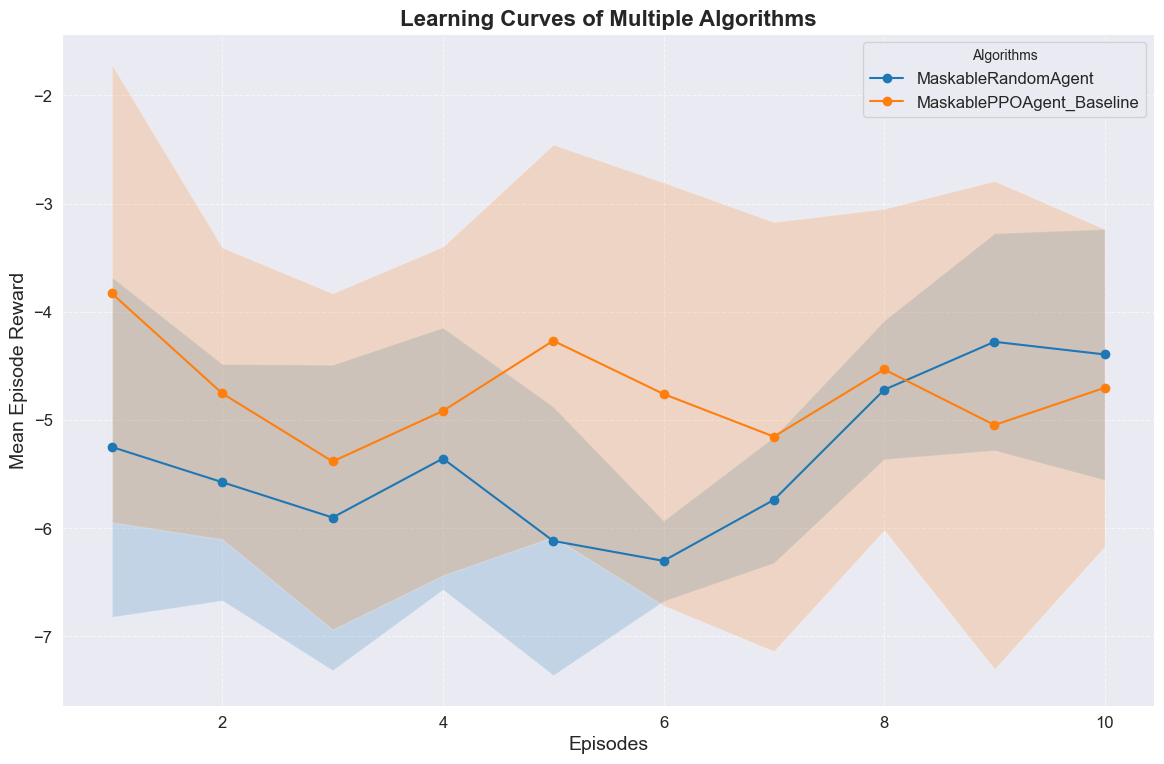

In [ ]:
#| export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(maskable_ppo_agent.optimize_agent, n_trials=N_TRAILS, n_jobs=N_JOBS)

print("Best trial:", study.best_trial)

[I 2025-02-22 12:00:53,413] A new study created in memory with name: no-name-092526af-0e28-4e42-8715-e66db0d6b7fb













seeds:   0%|          | 0/1 [00:00<?, ?it/s]













seeds:   0%|          | 0/1 [00:00<?, ?it/s]















seeds:   0%|          | 0/1 [00:00<?, ?it/s]














seeds:   0%|          | 0/1 [00:00<?, ?it/s]

















seeds:   0%|          | 0/1 [00:00<?, ?it/s]
















seeds:   0%|          | 0/1 [00:00<?, ?it/s]


















 ... (more hidden) ...















seeds: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


















seeds: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it][A
[I 2025-02-22 12:00:58,236] Trial 3 finished with value: -6.5506462999999995 and parameters: {'learning_rate': 9.083837595737127e-05, 'n_steps': 35, 'batch_size': 109, 'gamma': 0.9114157595611269, 'gae_lambda': 0.8948399240781547, 'ent_coef': 0.003232898348612501, 'vf_coef': 0.6778652876106586, 'clip_range': 0.20168145842911656, 'max_grad_norm'

Best trial: FrozenTrial(number=6, state=1, values=[-0.8751361], datetime_start=datetime.datetime(2025, 2, 22, 12, 0, 53, 428983), datetime_complete=datetime.datetime(2025, 2, 22, 12, 0, 58, 562438), params={'learning_rate': 0.0002722350600860288, 'n_steps': 46, 'batch_size': 254, 'gamma': 0.924969780568073, 'gae_lambda': 0.8207743850827881, 'ent_coef': 0.0030782916663708317, 'vf_coef': 0.29987906034194395, 'clip_range': 0.2641630268363363, 'max_grad_norm': 0.28600085259471086}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'n_steps': IntDistribution(high=1024, log=True, low=32, step=1), 'batch_size': IntDistribution(high=256, log=True, low=16, step=1), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.9, step=None), 'gae_lambda': FloatDistribution(high=1.0, log=False, low=0.8, step=None), 'ent_coef': FloatDistribution(high=0.02, log=False, low=0.0, step=None), 'vf_coef': Floa

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Optimized"] = maskable_ppo_agent.evaluate_policy(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=False)














seeds:   0%|          | 0/1 [00:00<?, ?it/s]













frames:   0%|          | 0/5 [00:00<?, ?it/s]













frames:  20%|██        | 1/5 [00:03<00:13,  3.39s/it]













frames:  40%|████      | 2/5 [00:06<00:10,  3.42s/it]













frames:  60%|██████    | 3/5 [00:10<00:06,  3.43s/it]













frames:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]













frames: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]













                                                     












seeds: 100%|██████████| 1/1 [00:17<00:00, 17.16s/it]


Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-6.671406 -5.607535 -5.215705 -7.821094 -7.666223 -7.836345 -9.509076
   -7.446917 -7.381624 -8.575796]
  [-0.899111 -4.587418 -1.113788  0.56225  -5.23004  -1.529939 -6.175857
   -0.935407 -4.592528 -3.64867 ]
  [-8.266231 -9.486477 -7.802942 -8.311048 -8.281686 -8.354195 -8.915061
   -8.906234 -8.85974  -8.87736 ]
  [-7.125819 -5.968001 -7.660525 -8.271015 -6.37486  -6.411752 -8.213624
   -8.392625 -7.037648 -7.708666]
  [-5.532738 -5.991743 -2.970833 -4.011016 -5.531023 -6.528694 -3.949615
   -1.535252 -4.975941 -4.534832]]]


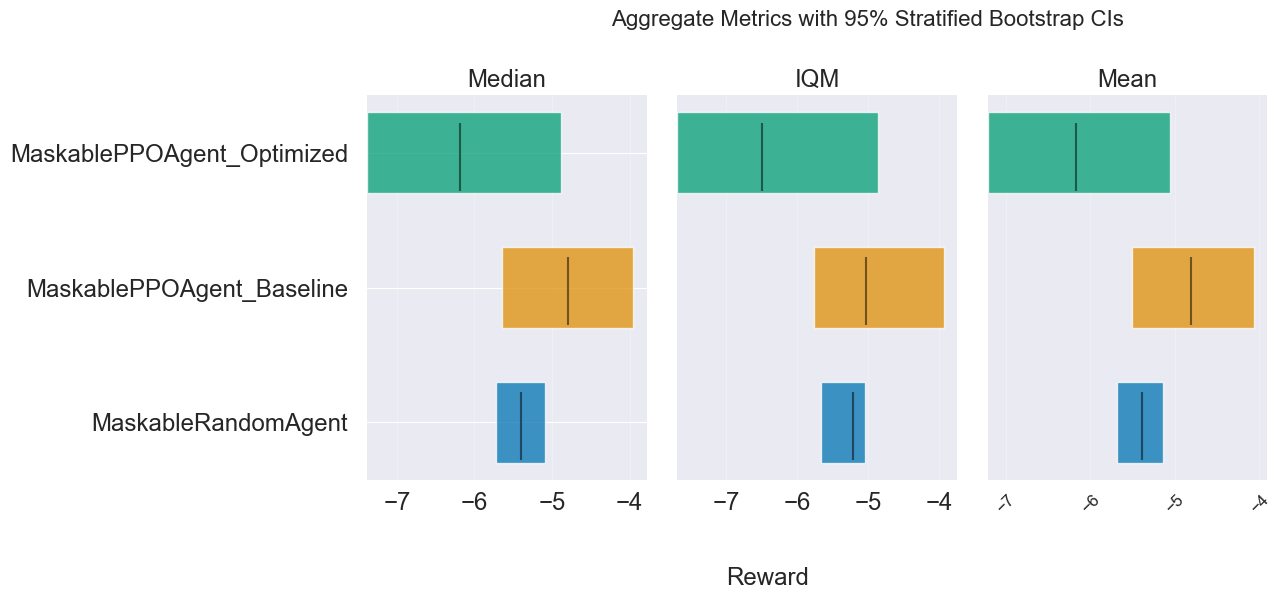

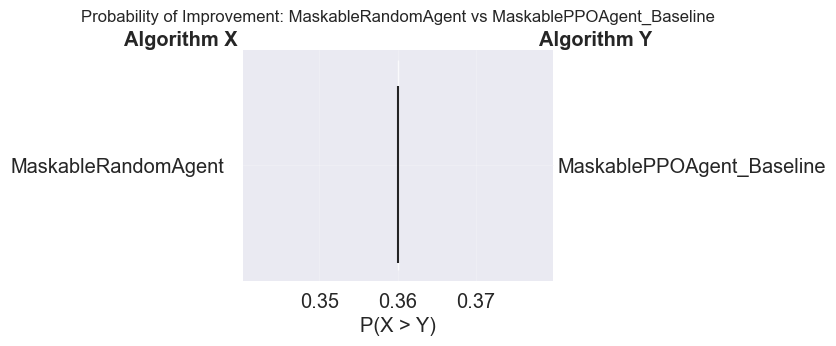

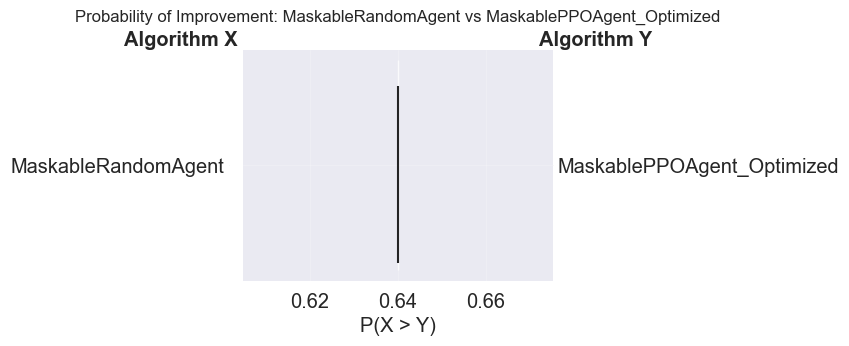

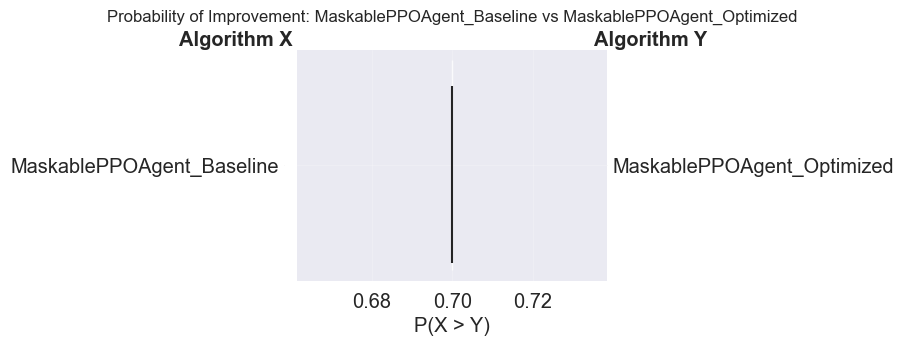

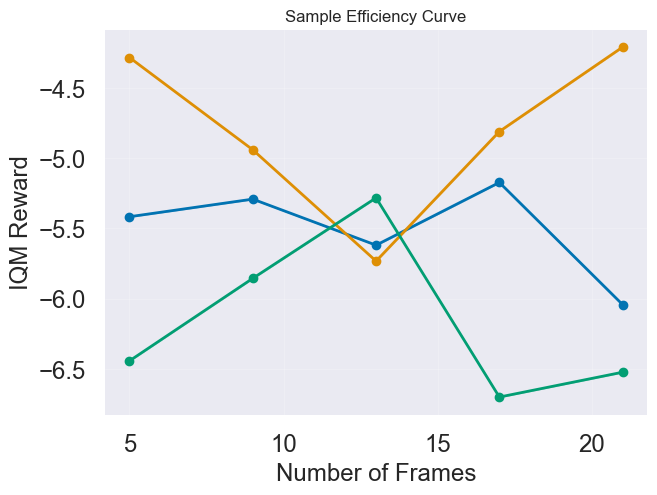

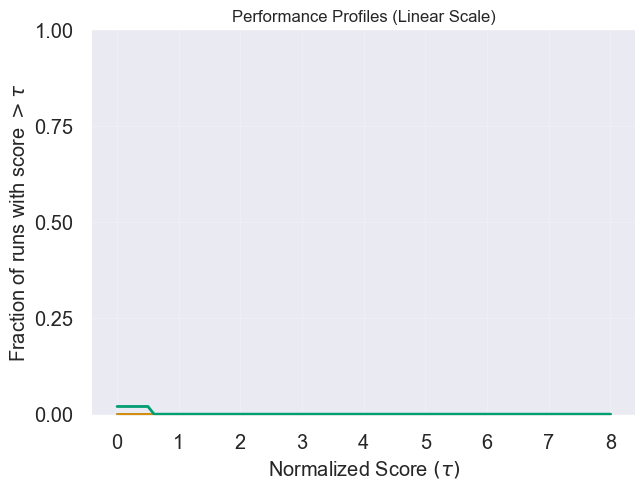

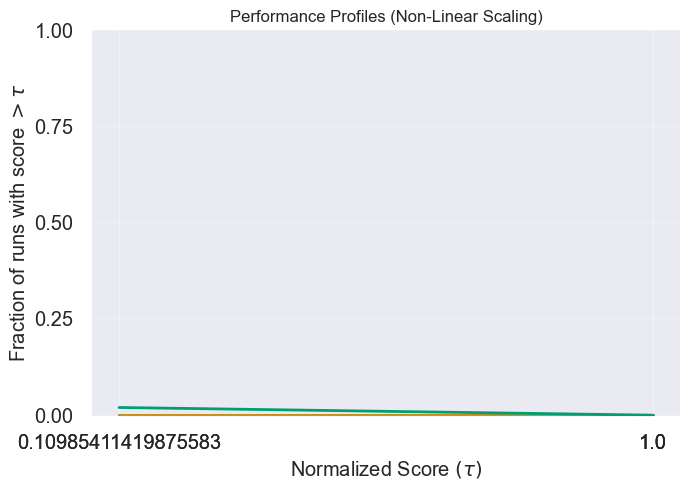

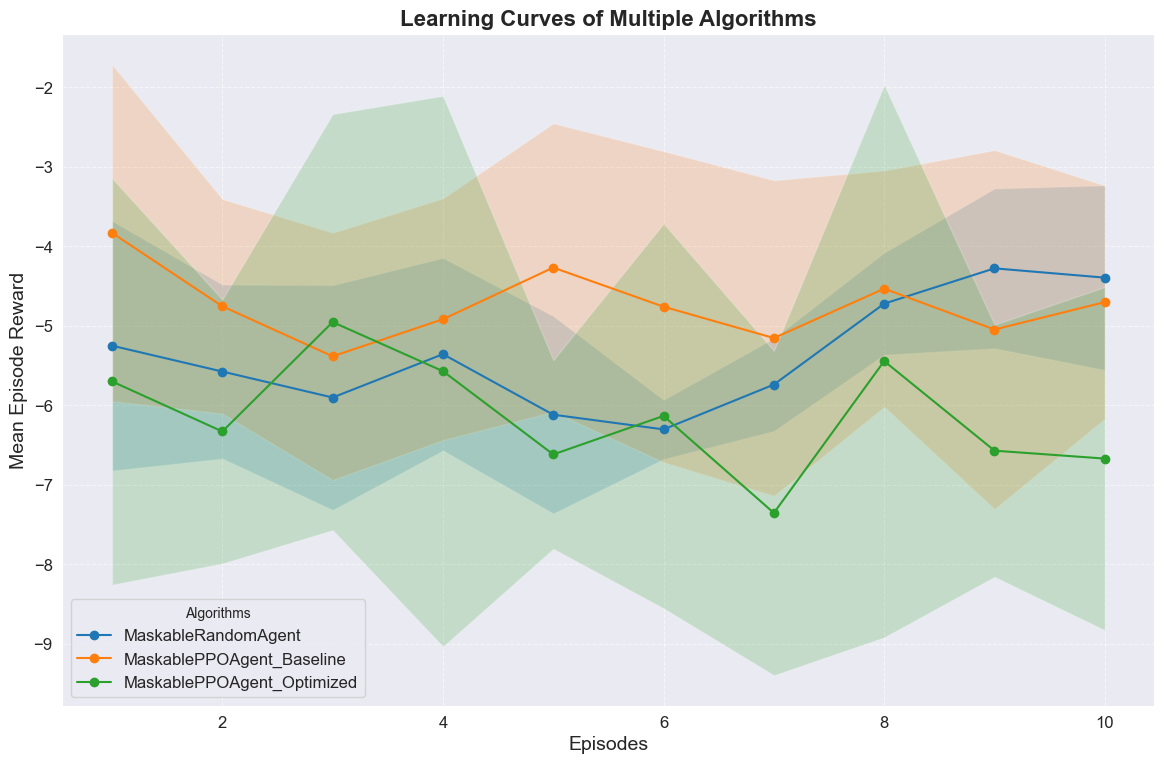

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()